## Dependências

In [93]:
import os
import evaluate
import torch
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import load_dataset, DatasetDict
from transformers import GraphormerForGraphClassification, TrainingArguments, Trainer
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

## Variáveis

In [94]:
load_dotenv()

token = os.getenv("TOKEN")

## Dataset

In [95]:
dataset = load_dataset("graphs-datasets/MUTAG", cache_dir="../datasets")
dataset = dataset.shuffle(seed=0)

In [96]:
dataset['train'] = dataset['train'].remove_columns(['edge_attr'])
dataset = dataset['train'].train_test_split(test_size=0.2)
test_valid = dataset['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': dataset['train'],
    'test': test_valid['train'],
    'validation': test_valid['test']})

dataset["train"].features

{'edge_index': List(List(Value('int64'))),
 'node_feat': List(List(Value('float64'))),
 'y': List(Value('int64')),
 'num_nodes': Value('int64')}

## Métricas

In [97]:
metric = evaluate.load("accuracy")

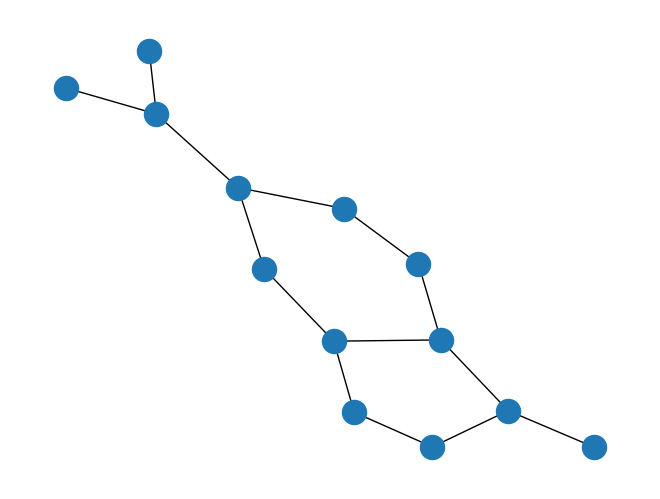

In [98]:
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

nx.draw(G)

In [99]:
"Label:" + str(graph['y'])

'Label:[0]'

## Processamento de Dados

In [100]:
dataset_processed = dataset.map(preprocess_item, batched=False)
train_ds = dataset_processed['train']
val_ds = dataset_processed['validation']

In [101]:
train_ds[0].keys()

dict_keys(['edge_index', 'node_feat', 'y', 'num_nodes', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels'])

## Modelo

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [103]:
model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    token=token,
    num_classes=2,
    ignore_mismatched_sizes=True
).to(device)

Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/pcqm4mv2_graphormer_base and are newly initialized because the shapes did not match:
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Argumentos

In [ ]:
training_args = TrainingArguments(
    output_dir="../results",
    logging_dir="graph-classification",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    auto_find_batch_size=False,
    gradient_accumulation_steps=10,
    dataloader_num_workers=4, 
    num_train_epochs=20,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    fp16=True, # Usar precisão mista para economizar memória
    dataloader_pin_memory=True # Acelerar transferência CPU-GPU
)

## Treino

In [105]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=GraphormerDataCollator()
)

In [108]:
train_results = trainer.train()

  5%|▌         | 3/60 [00:06<01:19,  1.39s/it]

{'loss': 0.3017, 'grad_norm': 5.1346049308776855, 'learning_rate': 4.75e-05, 'epoch': 0.79}






                                       
                                              
  5%|▌         | 3/60 [00:10<01:19,  1.39s/it]


{'eval_loss': 0.1496928483247757, 'eval_runtime': 4.1566, 'eval_samples_per_second': 4.571, 'eval_steps_per_second': 1.203, 'epoch': 0.79}


 12%|█▏        | 7/60 [00:16<01:28,  1.66s/it]

{'loss': 0.2557, 'grad_norm': 11.216084480285645, 'learning_rate': 4.4166666666666665e-05, 'epoch': 1.84}






                                       
                                              
 12%|█▏        | 7/60 [00:20<01:28,  1.66s/it]


{'eval_loss': 0.14350785315036774, 'eval_runtime': 3.9541, 'eval_samples_per_second': 4.805, 'eval_steps_per_second': 1.265, 'epoch': 1.84}


 18%|█▊        | 11/60 [00:27<01:23,  1.70s/it]

{'loss': 0.2849, 'grad_norm': 24.305395126342773, 'learning_rate': 4.0833333333333334e-05, 'epoch': 2.89}






                                       
                                               
 18%|█▊        | 11/60 [00:31<01:23,  1.70s/it]


{'eval_loss': 0.09759010374546051, 'eval_runtime': 4.092, 'eval_samples_per_second': 4.643, 'eval_steps_per_second': 1.222, 'epoch': 2.89}


 25%|██▌       | 15/60 [00:38<01:17,  1.73s/it]

{'loss': 0.1985, 'grad_norm': 3.267259359359741, 'learning_rate': 3.7500000000000003e-05, 'epoch': 3.95}






                                       
                                               
 25%|██▌       | 15/60 [00:42<01:17,  1.73s/it]


{'eval_loss': 0.1898392289876938, 'eval_runtime': 3.9931, 'eval_samples_per_second': 4.758, 'eval_steps_per_second': 1.252, 'epoch': 3.95}


 32%|███▏      | 19/60 [00:48<01:18,  1.91s/it]

{'loss': 0.1874, 'grad_norm': 4.816305160522461, 'learning_rate': 3.4166666666666666e-05, 'epoch': 5.0}






                                       
                                               
 32%|███▏      | 19/60 [00:52<01:18,  1.91s/it]


{'eval_loss': 0.1165427640080452, 'eval_runtime': 3.9347, 'eval_samples_per_second': 4.829, 'eval_steps_per_second': 1.271, 'epoch': 5.0}


 37%|███▋      | 22/60 [00:58<01:21,  2.14s/it]

{'loss': 0.2305, 'grad_norm': 6.126836776733398, 'learning_rate': 3.1666666666666666e-05, 'epoch': 5.79}






                                       
                                               
 37%|███▋      | 22/60 [01:02<01:21,  2.14s/it]


{'eval_loss': 0.21159839630126953, 'eval_runtime': 3.8933, 'eval_samples_per_second': 4.88, 'eval_steps_per_second': 1.284, 'epoch': 5.79}


 43%|████▎     | 26/60 [01:08<01:00,  1.78s/it]

{'loss': 0.1794, 'grad_norm': 5.839956283569336, 'learning_rate': 2.8333333333333335e-05, 'epoch': 6.84}






                                       
                                               
 43%|████▎     | 26/60 [01:12<01:00,  1.78s/it]


{'eval_loss': 0.11470851302146912, 'eval_runtime': 3.8763, 'eval_samples_per_second': 4.902, 'eval_steps_per_second': 1.29, 'epoch': 6.84}


 50%|█████     | 30/60 [01:19<00:51,  1.70s/it]

{'loss': 0.1784, 'grad_norm': 8.16125202178955, 'learning_rate': 2.5e-05, 'epoch': 7.89}






                                       
                                               
 50%|█████     | 30/60 [01:23<00:51,  1.70s/it]


{'eval_loss': 0.06727273762226105, 'eval_runtime': 3.9145, 'eval_samples_per_second': 4.854, 'eval_steps_per_second': 1.277, 'epoch': 7.89}


 57%|█████▋    | 34/60 [01:29<00:43,  1.68s/it]

{'loss': 0.142, 'grad_norm': 2.4483351707458496, 'learning_rate': 2.1666666666666667e-05, 'epoch': 8.95}






                                       
                                               
 57%|█████▋    | 34/60 [01:33<00:43,  1.68s/it]


{'eval_loss': 0.0675857663154602, 'eval_runtime': 3.8864, 'eval_samples_per_second': 4.889, 'eval_steps_per_second': 1.287, 'epoch': 8.95}


 63%|██████▎   | 38/60 [01:39<00:41,  1.88s/it]

{'loss': 0.1685, 'grad_norm': 6.002943992614746, 'learning_rate': 1.8333333333333333e-05, 'epoch': 10.0}






                                       
                                               
 63%|██████▎   | 38/60 [01:43<00:41,  1.88s/it]


{'eval_loss': 0.08189316093921661, 'eval_runtime': 3.8963, 'eval_samples_per_second': 4.876, 'eval_steps_per_second': 1.283, 'epoch': 10.0}


 68%|██████▊   | 41/60 [01:49<00:39,  2.09s/it]

{'loss': 0.1766, 'grad_norm': 6.281411647796631, 'learning_rate': 1.5833333333333333e-05, 'epoch': 10.79}






                                       
                                               
 68%|██████▊   | 41/60 [01:53<00:39,  2.09s/it]


{'eval_loss': 0.11500131338834763, 'eval_runtime': 3.9047, 'eval_samples_per_second': 4.866, 'eval_steps_per_second': 1.281, 'epoch': 10.79}


 75%|███████▌  | 45/60 [02:00<00:27,  1.83s/it]

{'loss': 0.1297, 'grad_norm': 6.775887489318848, 'learning_rate': 1.25e-05, 'epoch': 11.84}






                                       
                                               
 75%|███████▌  | 45/60 [02:04<00:27,  1.83s/it]


{'eval_loss': 0.12411589175462723, 'eval_runtime': 3.9227, 'eval_samples_per_second': 4.844, 'eval_steps_per_second': 1.275, 'epoch': 11.84}


 82%|████████▏ | 49/60 [02:10<00:18,  1.72s/it]

{'loss': 0.1339, 'grad_norm': 6.025745868682861, 'learning_rate': 9.166666666666666e-06, 'epoch': 12.89}






                                       
                                               
 82%|████████▏ | 49/60 [02:14<00:18,  1.72s/it]


{'eval_loss': 0.16318868100643158, 'eval_runtime': 3.8949, 'eval_samples_per_second': 4.878, 'eval_steps_per_second': 1.284, 'epoch': 12.89}


 88%|████████▊ | 53/60 [02:21<00:12,  1.75s/it]

{'loss': 0.1242, 'grad_norm': 3.4871535301208496, 'learning_rate': 5.833333333333334e-06, 'epoch': 13.95}






                                       
                                               
 88%|████████▊ | 53/60 [02:25<00:12,  1.75s/it]


{'eval_loss': 0.1308620721101761, 'eval_runtime': 4.014, 'eval_samples_per_second': 4.733, 'eval_steps_per_second': 1.246, 'epoch': 13.95}


 95%|█████████▌| 57/60 [02:31<00:05,  1.97s/it]

{'loss': 0.1182, 'grad_norm': 7.057626247406006, 'learning_rate': 2.5e-06, 'epoch': 15.0}






                                       
                                               
 95%|█████████▌| 57/60 [02:35<00:05,  1.97s/it]


{'eval_loss': 0.08089587837457657, 'eval_runtime': 3.9692, 'eval_samples_per_second': 4.787, 'eval_steps_per_second': 1.26, 'epoch': 15.0}


100%|██████████| 60/60 [02:41<00:00,  2.16s/it]

{'loss': 0.0845, 'grad_norm': 2.132795810699463, 'learning_rate': 0.0, 'epoch': 15.79}






                                       
                                               
100%|██████████| 60/60 [02:45<00:00,  2.16s/it]

100%|██████████| 60/60 [02:45<00:00,  2.76s/it]

{'eval_loss': 0.07374992966651917, 'eval_runtime': 3.896, 'eval_samples_per_second': 4.877, 'eval_steps_per_second': 1.283, 'epoch': 15.79}
{'train_runtime': 165.3912, 'train_samples_per_second': 18.139, 'train_steps_per_second': 0.363, 'train_loss': 0.17971153656641642, 'epoch': 15.79}


## Save

In [109]:
trainer.save_model(output_dir="../model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =    15.7895
  total_flos               =        0GF
  train_loss               =     0.1797
  train_runtime            = 0:02:45.39
  train_samples_per_second =     18.139
  train_steps_per_second   =      0.363
